# dpd incident response analytics

In [2]:
import pandas as pd 
from pymongo import MongoClient
import matplotlib.pyplot as plt
import time
import datetime
from IPython.display import clear_output
from scipy.interpolate import make_interp_spline
import numpy as np 

In [3]:
client = MongoClient()
client.DallasPD_DB
db = client['DallasPD_DB']
dpd_db = db.running_db
df = pd.DataFrame(list(dpd_db.find()))

In [4]:
df = pd.DataFrame(list(dpd_db.find()))
df.columns
dfc = df.drop('_id', axis = 1)
dfc = dfc.drop_duplicates()
dfc.sort_values(by = ['date', 'time']).head()
dfc['datetime'] = pd.to_datetime(dfc['date'].astype(str) + ' ' + dfc['time'])
dfc['day'] = dfc['datetime'].dt.day

In [6]:
dfc.head()

,incident_number,division,nature_of_call,priority,date,time,unit_number,location,beat,reporting_area,status,block,datetime,day
0,25-0285812,Southwest,40/01 - Other,2,2025-02-18,00:00:09,A451,Timberbluff Rd,436,8811,At Scene,NaN,2025-02-18 00:00:09,18
1,25-0285775,Central,41/11V - BMV-In Progress,2,2025-02-18,00:10:44,E121,Matalee Ave,141,1139,At Scene,5600,2025-02-18 00:10:44,18
2,25-0285818,South Central,37F - Freeway Blockage,2,2025-02-18,00:11:42,A736,S R L Thornton Fwy Sb / E Camp Wisdom Rd,743,4364,At Scene,NaN,2025-02-18 00:11:42,18
3,25-0285818,South Central,37F - Freeway Blockage,2,2025-02-18,00:11:42,A725,S R L Thornton Fwy Sb / E Camp Wisdom Rd,743,4364,At Scene,NaN,2025-02-18 00:11:42,18
4,25-0285902,North Central,DAEF-Dist Armed Encounter Foot,1,2025-02-18,00:14:56,E652,Marsh Ln,612,4423,At Scene,18800,2025-02-18 00:14:56,18


In [ ]:
# incidents reported by division 

In [17]:
df_i = dfc.drop('unit_number', axis = 1) 
df_i = df_i.drop_duplicates()
df_i.head()

,incident_number,division,nature_of_call,priority,date,time,location,beat,reporting_area,status,block,datetime,day
0,25-0285812,Southwest,40/01 - Other,2,2025-02-18,00:00:09,Timberbluff Rd,436,8811,At Scene,NaN,2025-02-18 00:00:09,18
1,25-0285775,Central,41/11V - BMV-In Progress,2,2025-02-18,00:10:44,Matalee Ave,141,1139,At Scene,5600,2025-02-18 00:10:44,18
2,25-0285818,South Central,37F - Freeway Blockage,2,2025-02-18,00:11:42,S R L Thornton Fwy Sb / E Camp Wisdom Rd,743,4364,At Scene,NaN,2025-02-18 00:11:42,18
4,25-0285902,North Central,DAEF-Dist Armed Encounter Foot,1,2025-02-18,00:14:56,Marsh Ln,612,4423,At Scene,18800,2025-02-18 00:14:56,18
5,25-0281246,Southeast,DAEF-Dist Armed Encounter Foot,1,2025-02-17,04:59:06,Canary Island Ct,354,2226,At Scene,1600,2025-02-17 04:59:06,17


In [ ]:
#view call types by divisions 

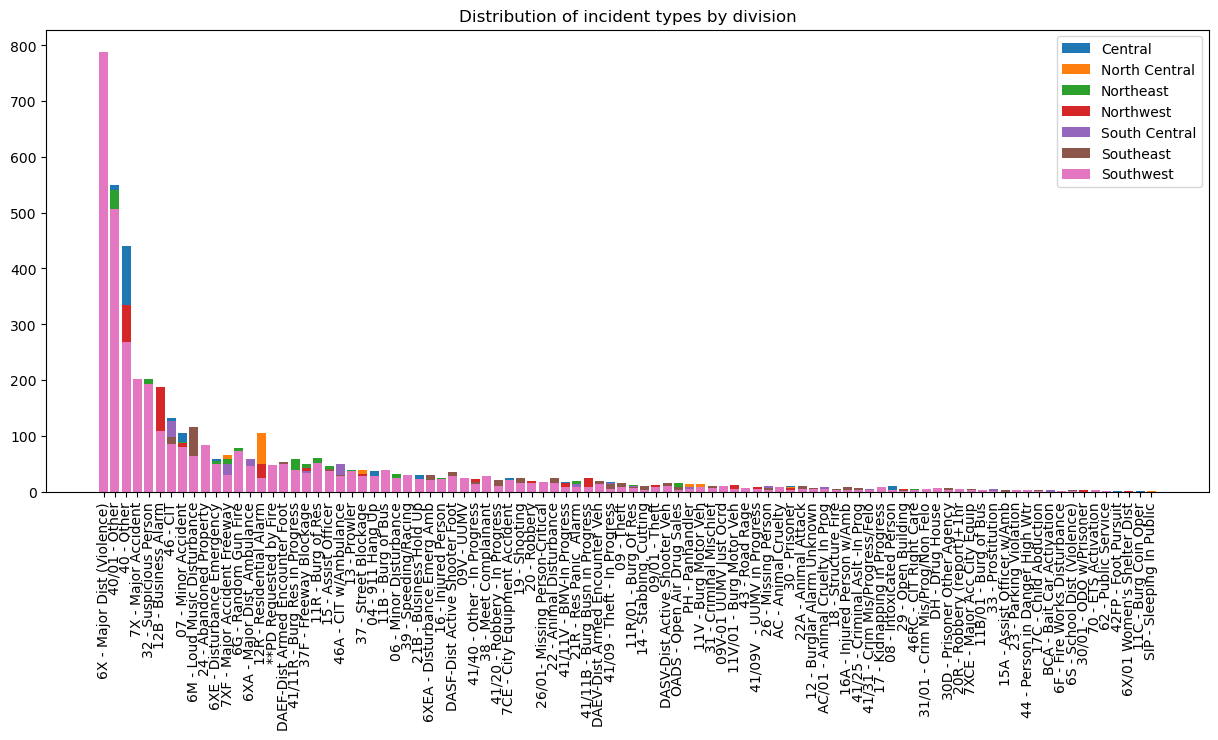

In [126]:
df_in = df_i.groupby(['division','nature_of_call'])['incident_number'].agg('count').reset_index()
plt_order = df_i.groupby(['nature_of_call'])['incident_number'].agg('count').reset_index().sort_values('incident_number', ascending = False)
plt_order_cumsum = plt_order['incident_number'].cumsum().to_list()
plt_order = plt_order['nature_of_call'].to_list()

plt.figure(figsize=(15, 6))
for division in df_in['division'].unique():
    df_temp = df_in[df_in['division'] == division]
    
    x = [df_temp[df_temp['nature_of_call'] == cat]['incident_number'].values[0] 
         if cat in df_temp['nature_of_call'].values else 0
         for cat in plt_order]
    plt.bar(plt_order, x)#, df_temp['nature_of_call'])
plt.xticks(rotation = 90)
plt.title("Distribution of incident types by division")
plt.legend(df_in['division'].unique())
plt.show()

# optional graph showing the less frequent incidents
# threshold = 0.50 * plt_order_cumsum[-1]
# second_half = next(i for i, val in enumerate(plt_order_cumsum) if val >= threshold)

# plt_order = plt_order[second_half:]
# plt.figure(figsize=(15, 6))
# for division in df_in['division'].unique():
#     df_temp = df_in[df_in['division'] == division]
    
#     x = [df_temp[df_temp['nature_of_call'] == cat]['incident_number'].values[0] 
#          if cat in df_temp['nature_of_call'].values else 0
#          for cat in plt_order]
#     plt.bar(plt_order, x)#, df_temp['nature_of_call'])
# plt.xticks(rotation = 90)
# plt.title("Distribution of incident types by division")
# plt.legend(df_in['division'].unique())
# plt.show()

# maybe alllow user to select different incident types

In [74]:
# filter based on day or time 

In [77]:
# want a df with crimes by division 
pd.set_option('display.max_rows', None)
df_cd = df_in.pivot_table(columns = 'division', index = 'nature_of_call', values = 'incident_number')
df_cd['Total'] = df_cd.sum(axis=1)
df_cd = df_cd.sort_values('Total', ascending = False).fillna(0)
df_cd

division,Central,North Central,Northeast,Northwest,South Central,Southeast,Southwest,Total
nature_of_call,,,,,,,,
6X - Major Dist (Violence),769.0,513.0,740.0,584.0,786.0,694.0,789.0,4875.0
40/01 - Other,550.0,376.0,540.0,461.0,417.0,439.0,507.0,3290.0
40 - Other,441.0,256.0,331.0,334.0,228.0,243.0,269.0,2102.0
7X - Major Accident,172.0,151.0,140.0,197.0,143.0,159.0,202.0,1164.0
32 - Suspicious Person,187.0,123.0,202.0,174.0,128.0,151.0,192.0,1157.0
12B - Business Alarm,92.0,98.0,105.0,187.0,41.0,80.0,109.0,712.0
46 - CIT,132.0,54.0,98.0,58.0,126.0,97.0,85.0,650.0
07 - Minor Accident,105.0,75.0,88.0,87.0,51.0,54.0,79.0,539.0
6M - Loud Music Disturbance,69.0,66.0,37.0,30.0,54.0,115.0,63.0,434.0


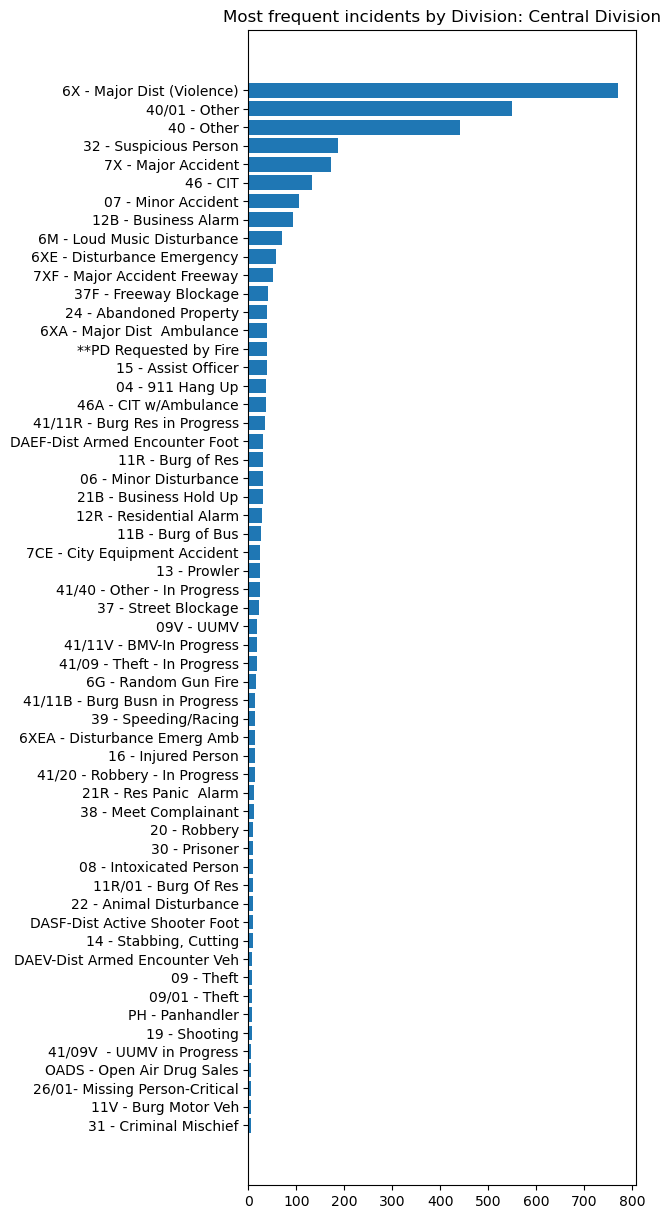

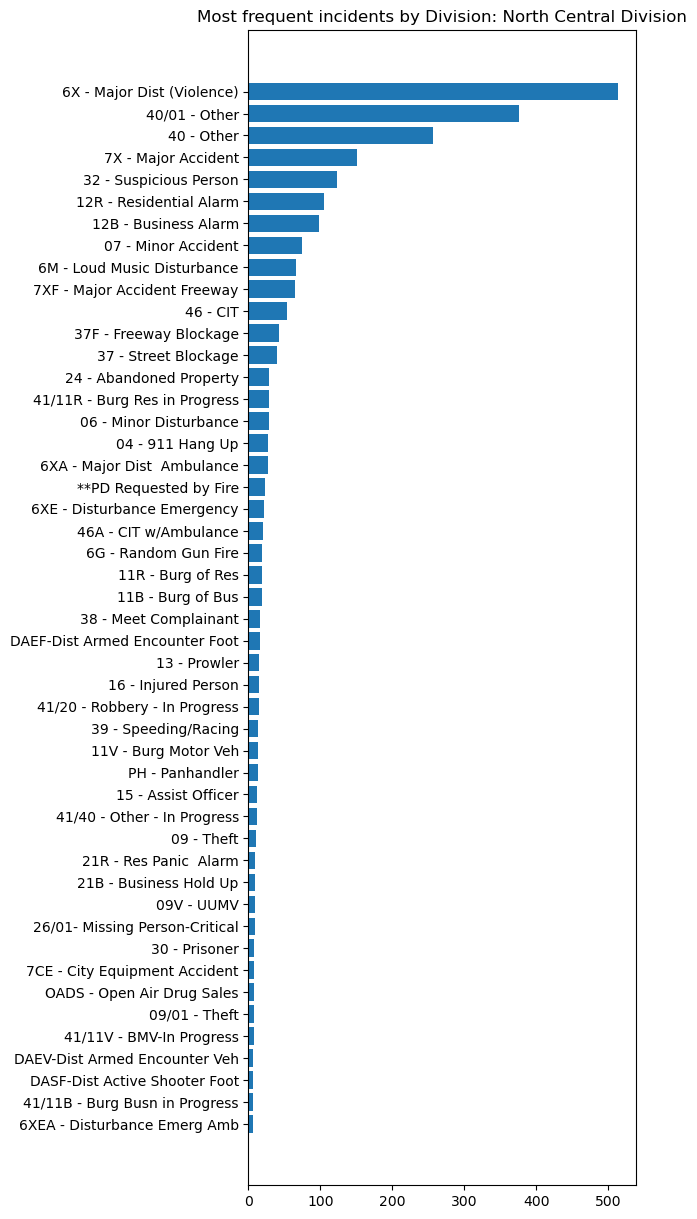

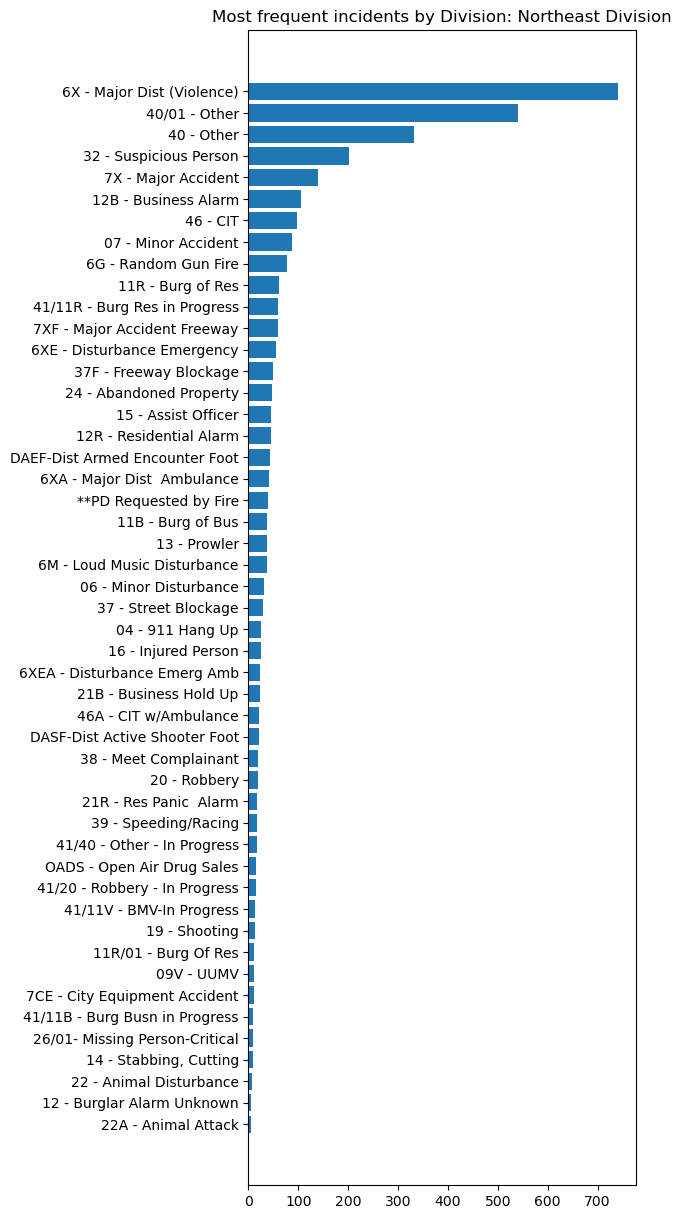

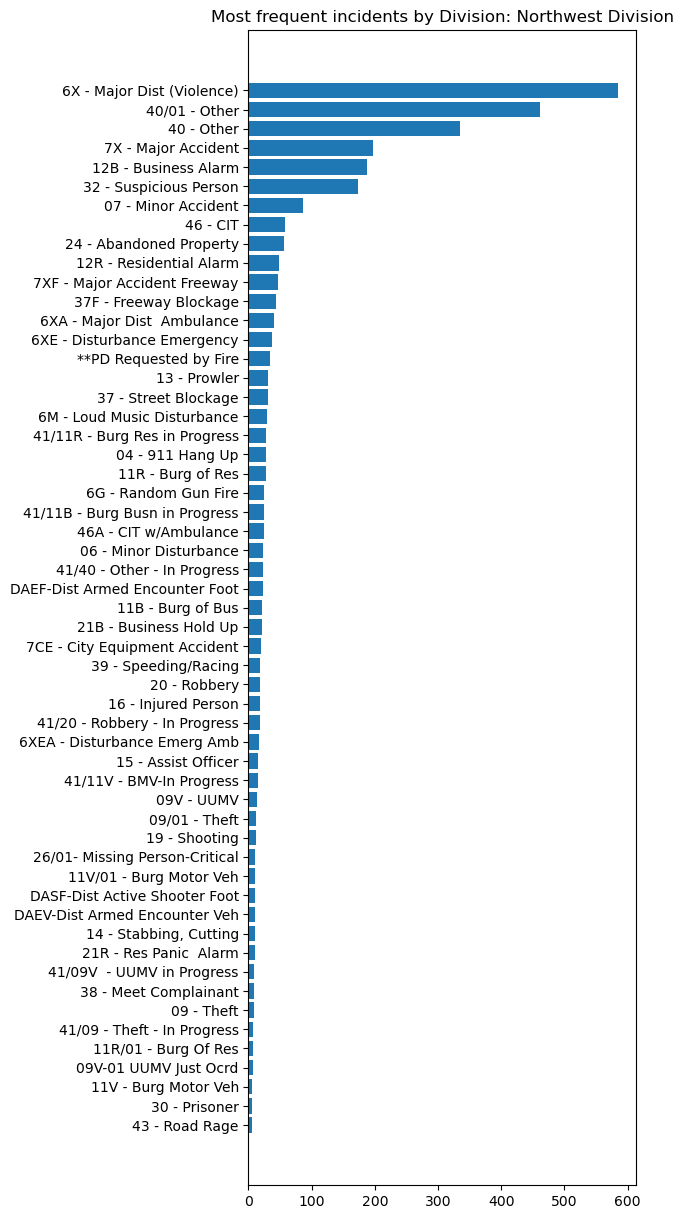

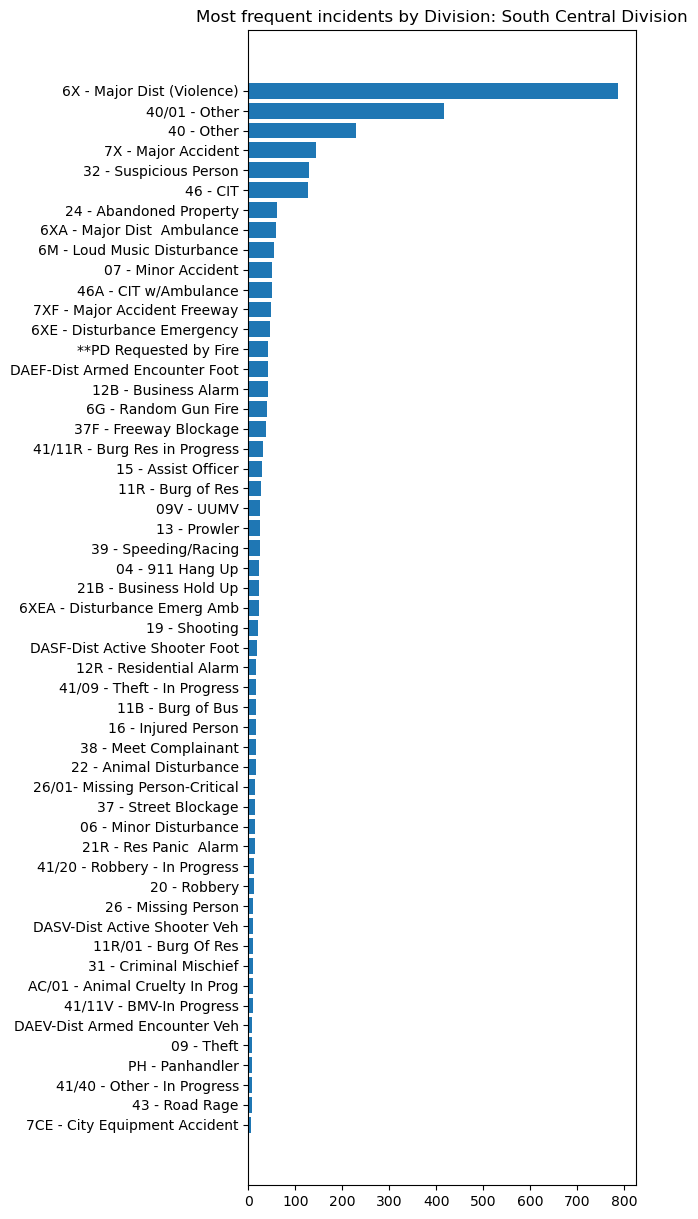

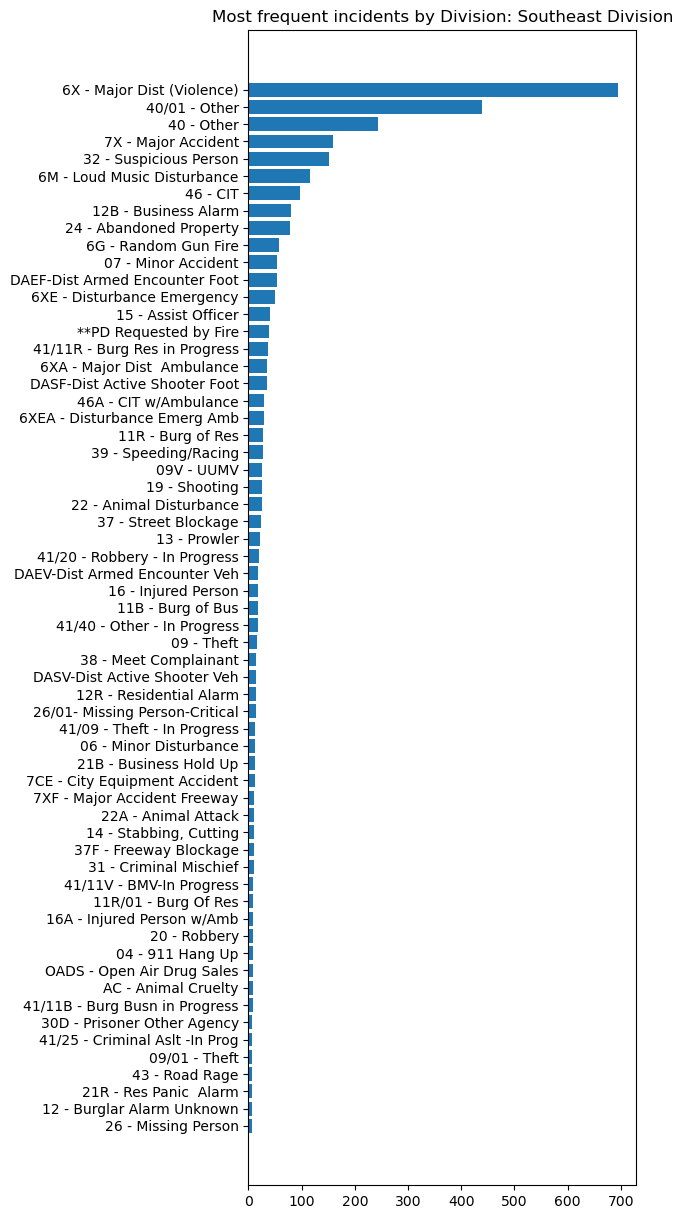

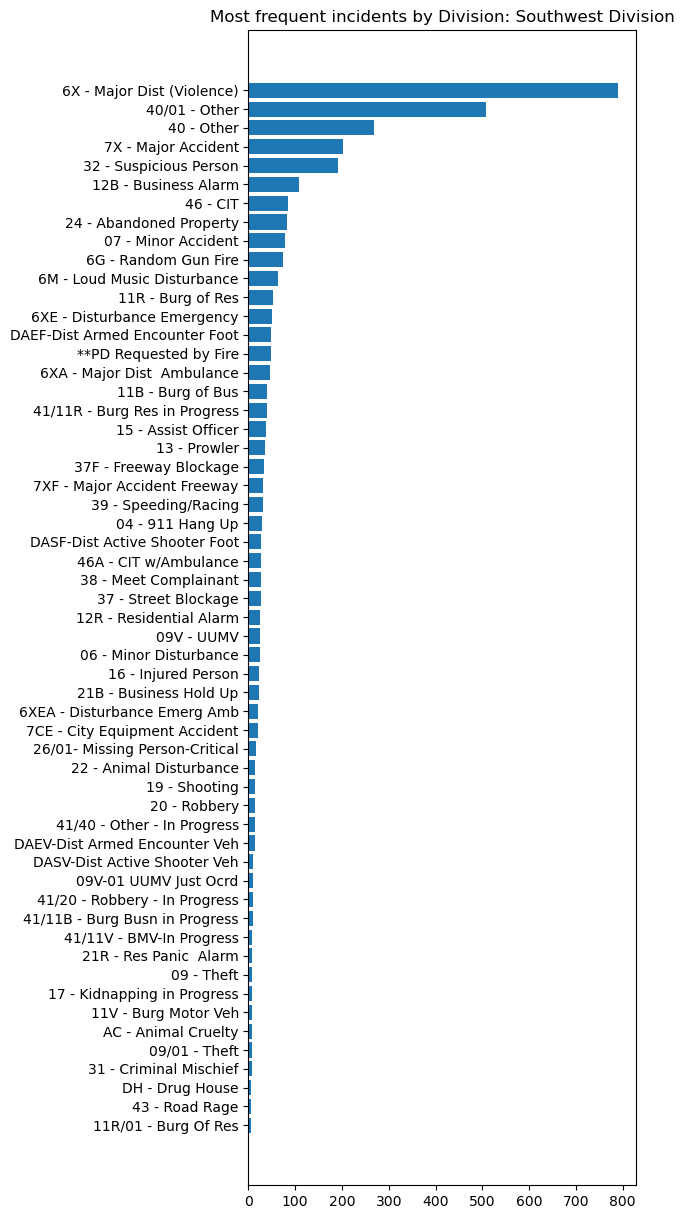

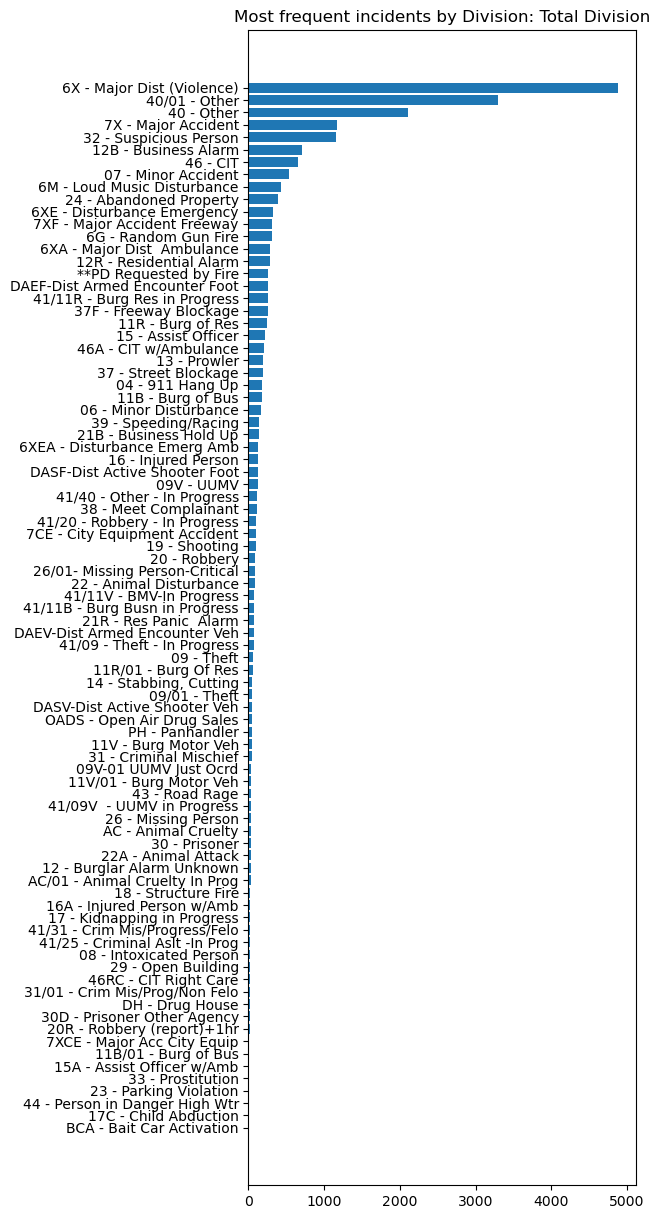

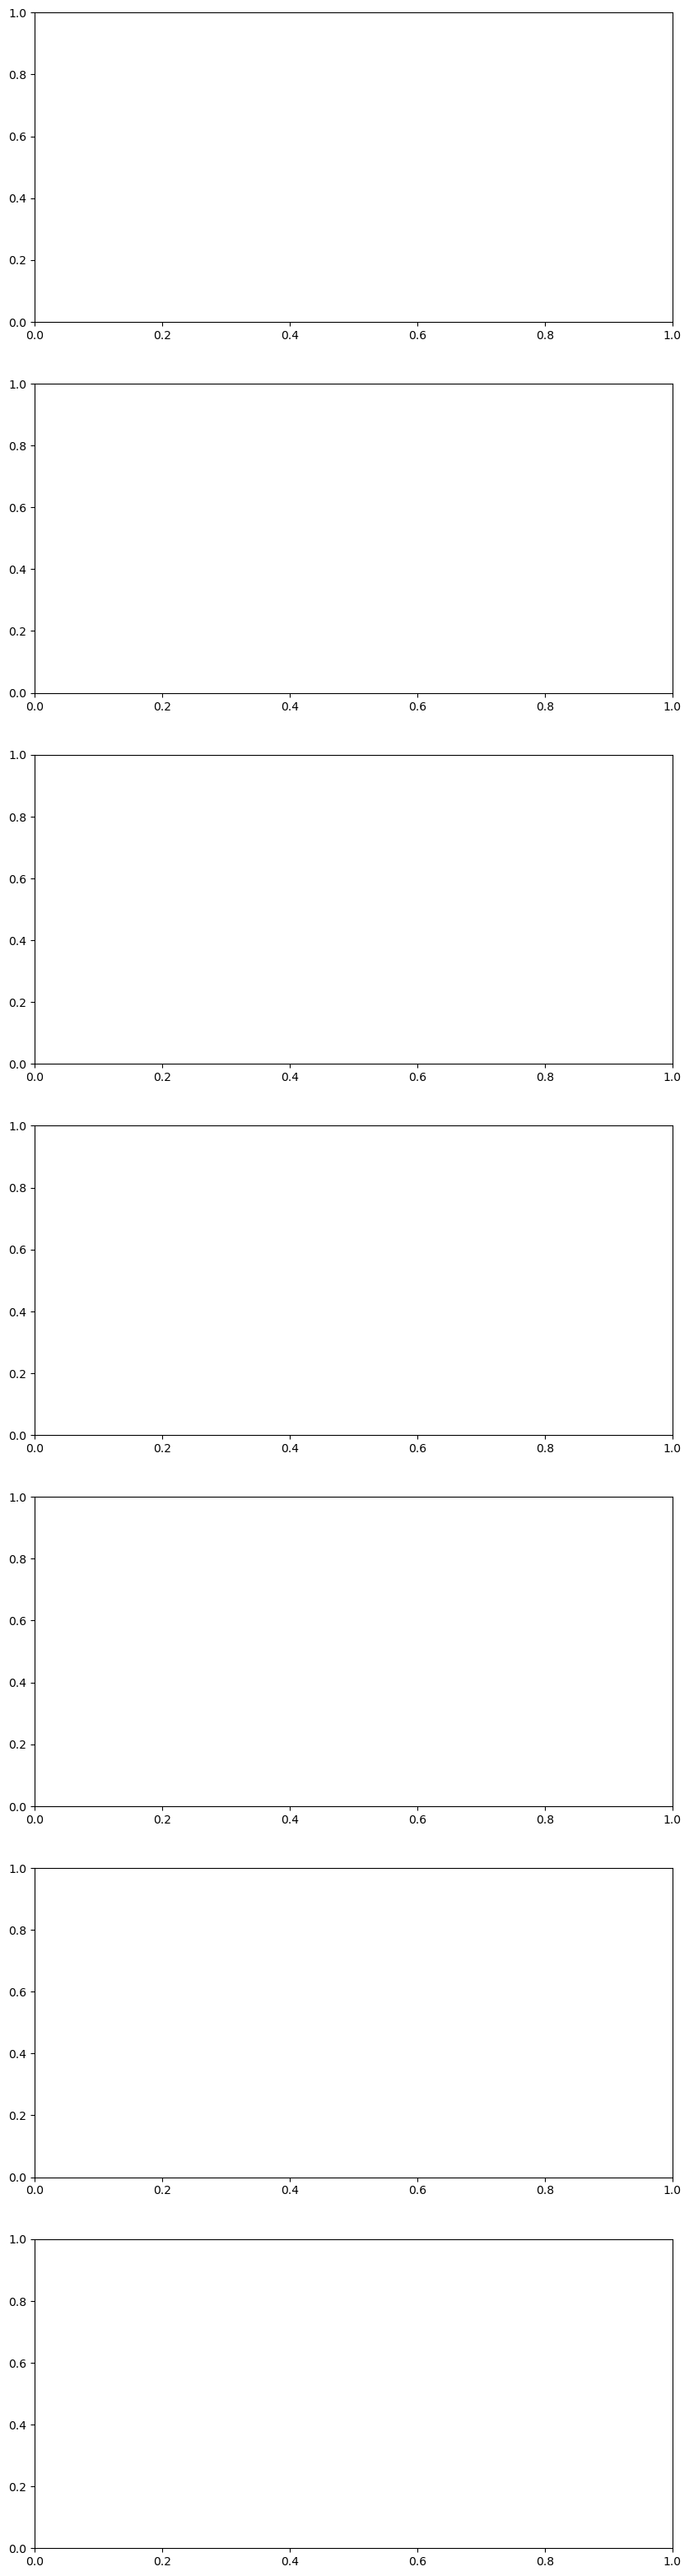

In [125]:
for division in df_cd.columns.to_list():
    temp_df = df_cd[division].reset_index().sort_values(division, ascending = True)
    temp_df = temp_df[temp_df[division]>5]
    plt.figure(figsize=(5, 15))
    plt.barh(temp_df['nature_of_call'], temp_df[division])
    plt.title(f"Most frequent incidents by Division: {division.title()} Division")
    plt.show()
    
fig, axes = plt.subplots(len(df_cd.columns) - 1, 1, figsize=(10, len(df_cd.columns) * 5))  # Adjust height based on number of divisions

3
